In this notebook, we do a quick comparison of an out-of-the-box GCN (without any hyperparameter tuning) against some naive baseline models. 

### imports and setup

In [136]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

# libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from lorenz import lorenzDataset, DEFAULT_TIME_RESOLUTION
from plotters import plot_data
from tuning import make_train_GCN, plot_model_results
from models import NaiveConstant, NaiveZero

from spektral.data import MixedLoader

from datetime import datetime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
# check that GPU is set up
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('no GPU device found')
else:
  print('found GPU at: {}'.format(device_name))
print('num GPUs available:', len(tf.config.list_physical_devices("GPU")))

no GPU device found
num GPUs available: 0


### prepare data

In [88]:
# only uncomment each line if testing a non-default parameter
dataset = lorenzDataset(
    n_samples=100000,
    # input_steps=2 * DEFAULT_TIME_RESOLUTION,  # 2 days
    # output_delay=1 * DEFAULT_TIME_RESOLUTION,  # 1 day
    # output_steps=1,
    min_buffer=-3 * DEFAULT_TIME_RESOLUTION,
    # rand_buffer=False,
    # K=36,
    # F=8,
    # c=10,
    # b=10,
    # h=1,
    # coupled=True,
    # time_resolution=DEFAULT_TIME_RESOLUTION,
    # seed=42
)

reading Lorenz data from stored file


In [89]:
train = dataset[:int(0.7 * dataset.n_graphs)]
val = dataset[int(0.7 * dataset.n_graphs):int(0.9 * dataset.n_graphs)]
test = dataset[int(0.9 * dataset.n_graphs):]


In [108]:
train_loader = MixedLoader(dataset=train, batch_size=32, shuffle=False)
val_loader = MixedLoader(dataset=val, batch_size=32, shuffle=False)


In [90]:
# TODO: store normalized train/val/test data

# normalize data
start = datetime.now()
X1_mean, X1_std, X2_mean, X2_std = train.get_mean_std()
finish_get_means = datetime.now()
print('time to get means:', finish_get_means - start)

train.normalize(X1_mean, X1_std, X2_mean, X2_std)
val.normalize(X1_mean, X1_std, X2_mean, X2_std)
test.normalize(X1_mean, X1_std, X2_mean, X2_std)
finish_normalize = datetime.now()

print('time to normalize data:', finish_normalize - finish_get_means)

time to concat: 0:00:52.326511
time to get std&mean from X1: 0:02:48.801891
time to get std&mean from X2: 0:09:48.700957
time to get means: 0:13:32.401125
time to normalize data: 0:01:59.644498


inspect data
(commented out because it takes too long to plot so many data points and I'm confident I know what it looks like)

In [91]:
# fig, (ax0, ax1) = plot_data(train, val, test, node=0)

# plt.tight_layout()
# plt.show()

## compare models and tune hyperparameters

### NaiveZero model
all predictions are 0.

In [118]:
naive_zero_model = NaiveZero()
naive_zero_model.compile(loss='mean_squared_error')

 5/25 [=====>........................] - ETA: 0s

[autoreload of tuning failed: Traceback (most recent call last):
  File "/Users/h.lu/Documents/_code/_research lorenz code/lorenzGNN/venv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/h.lu/Documents/_code/_research lorenz code/lorenzGNN/venv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/usr/local/Cellar/python@3.9/3.9.14/Frameworks/Python.framework/Versions/3.9/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/h.lu/Documents/_code/_research lorenz code/lorenzGNN/tuning.py", line 15, in <module>
    EARLY_STOPPING = EarlyStopping(monitor='val_loss',


25/25 [==============================] - 0s 5ms/step


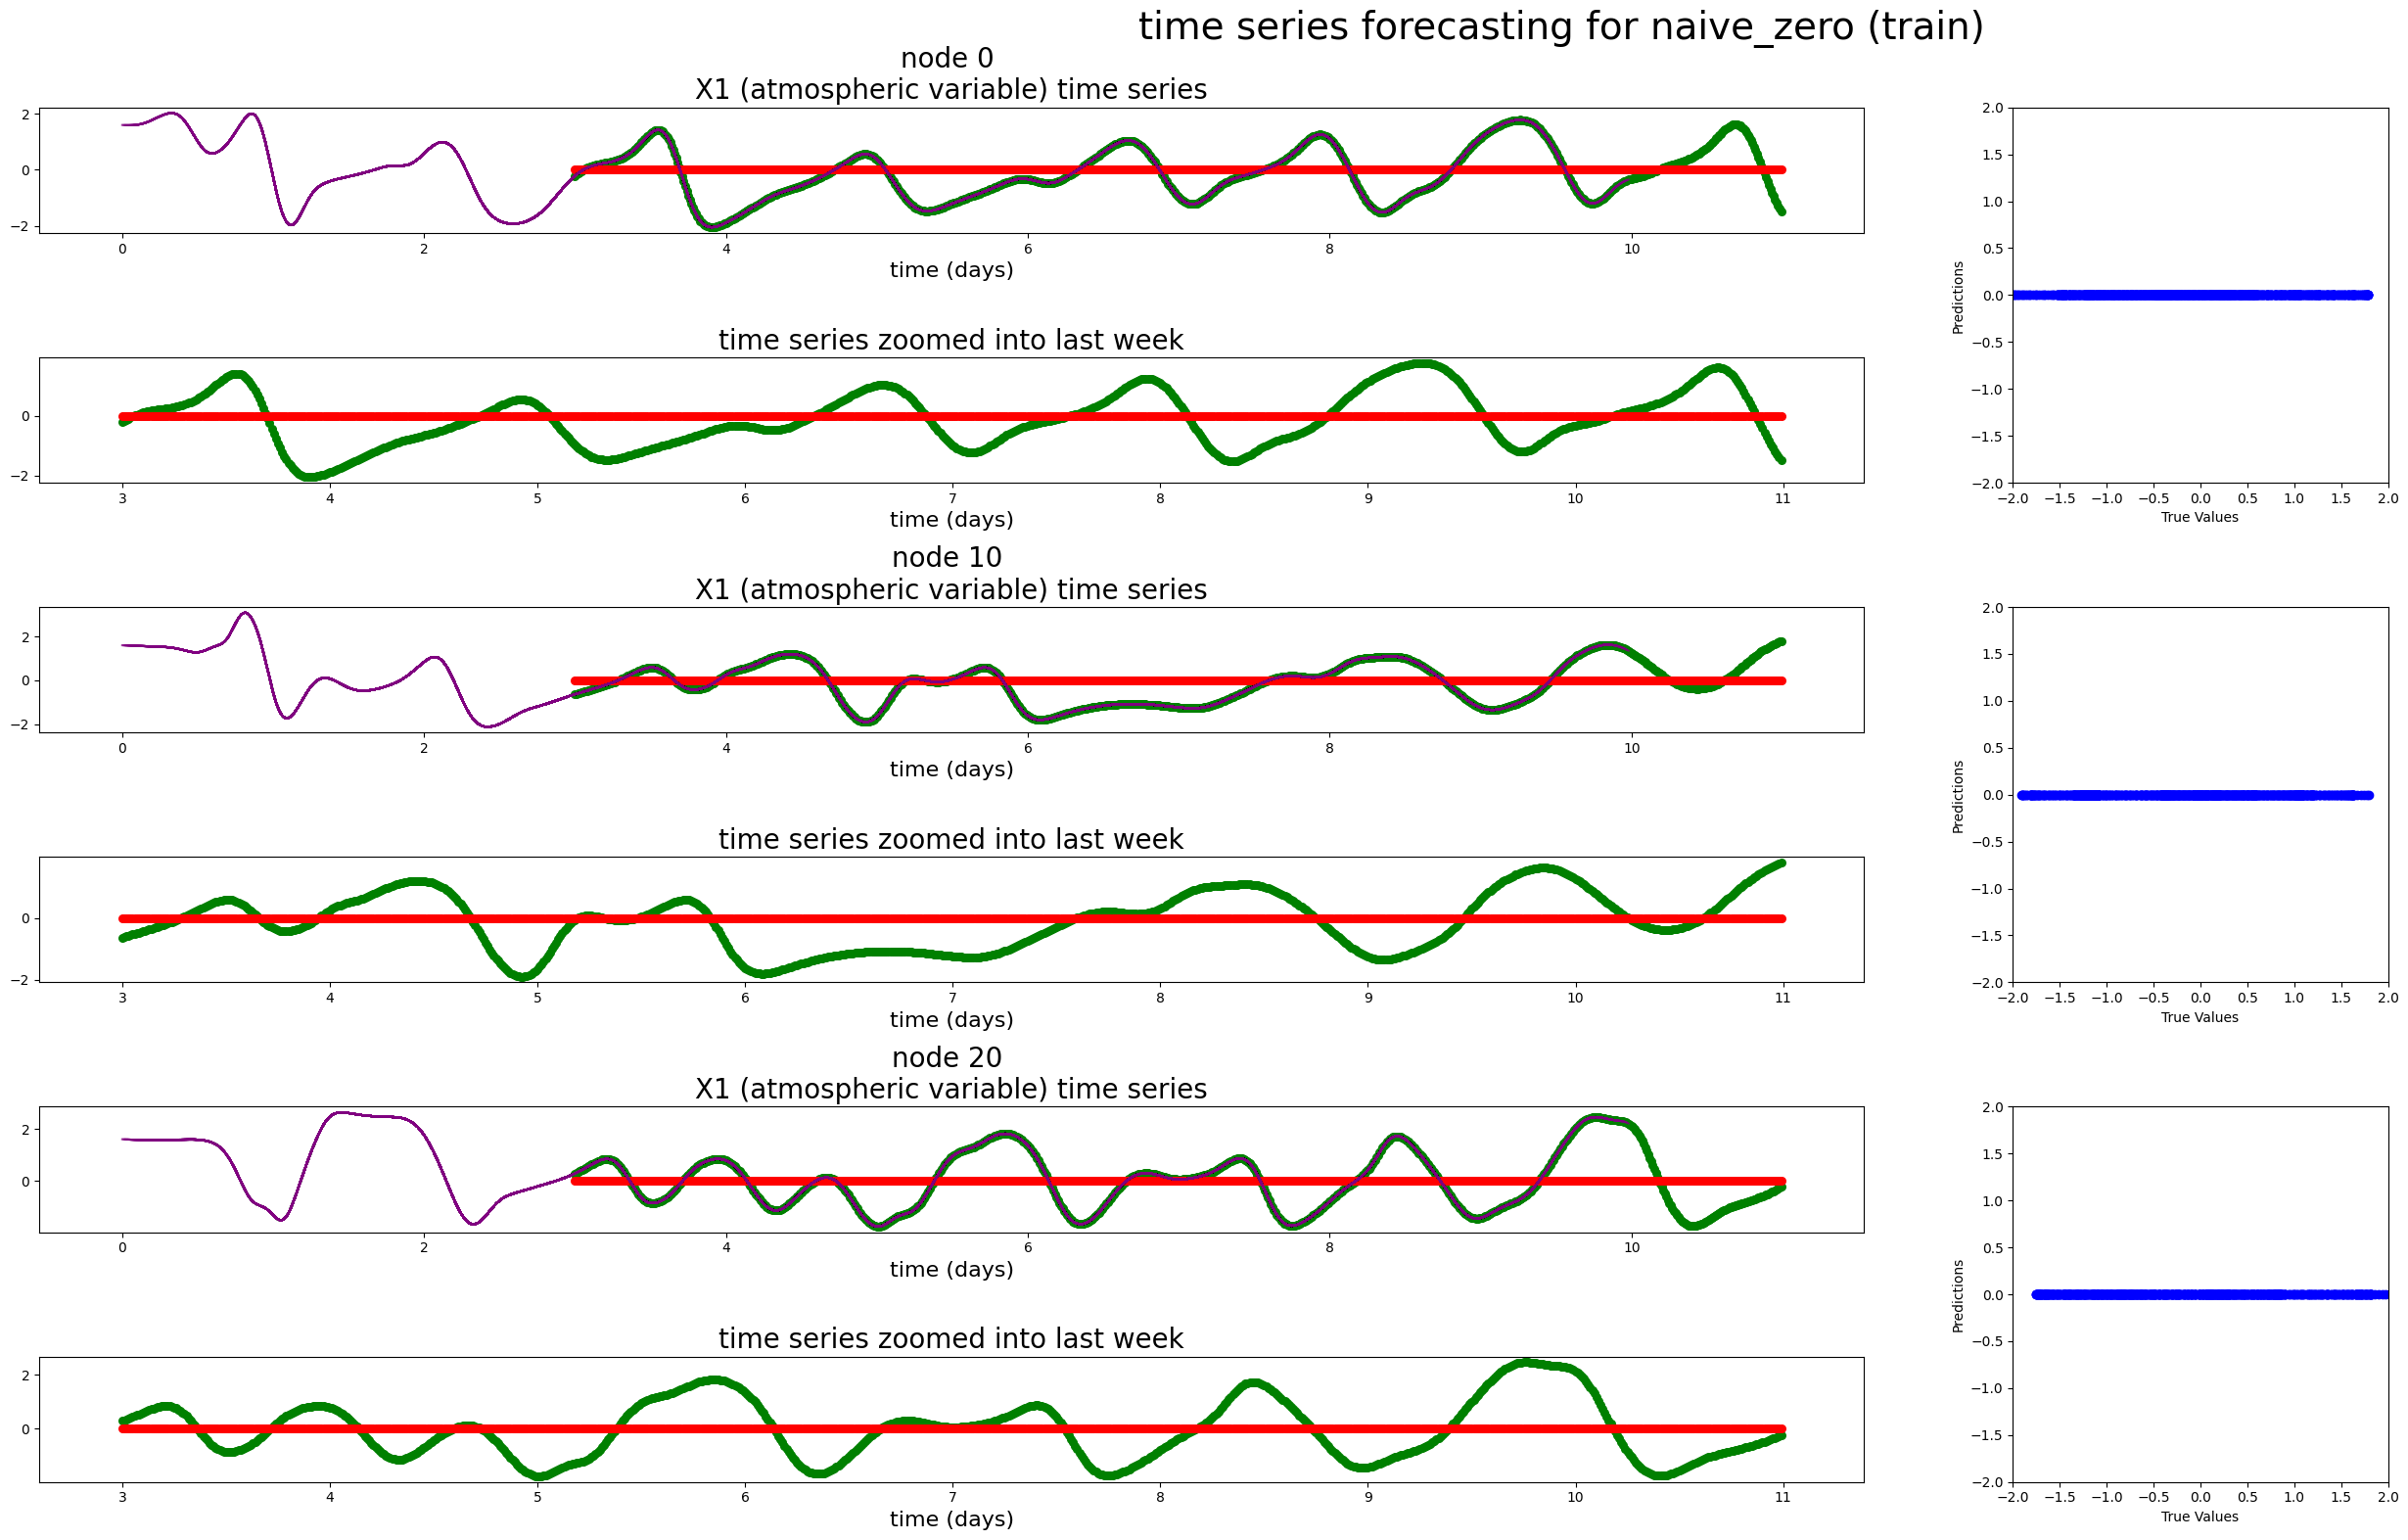

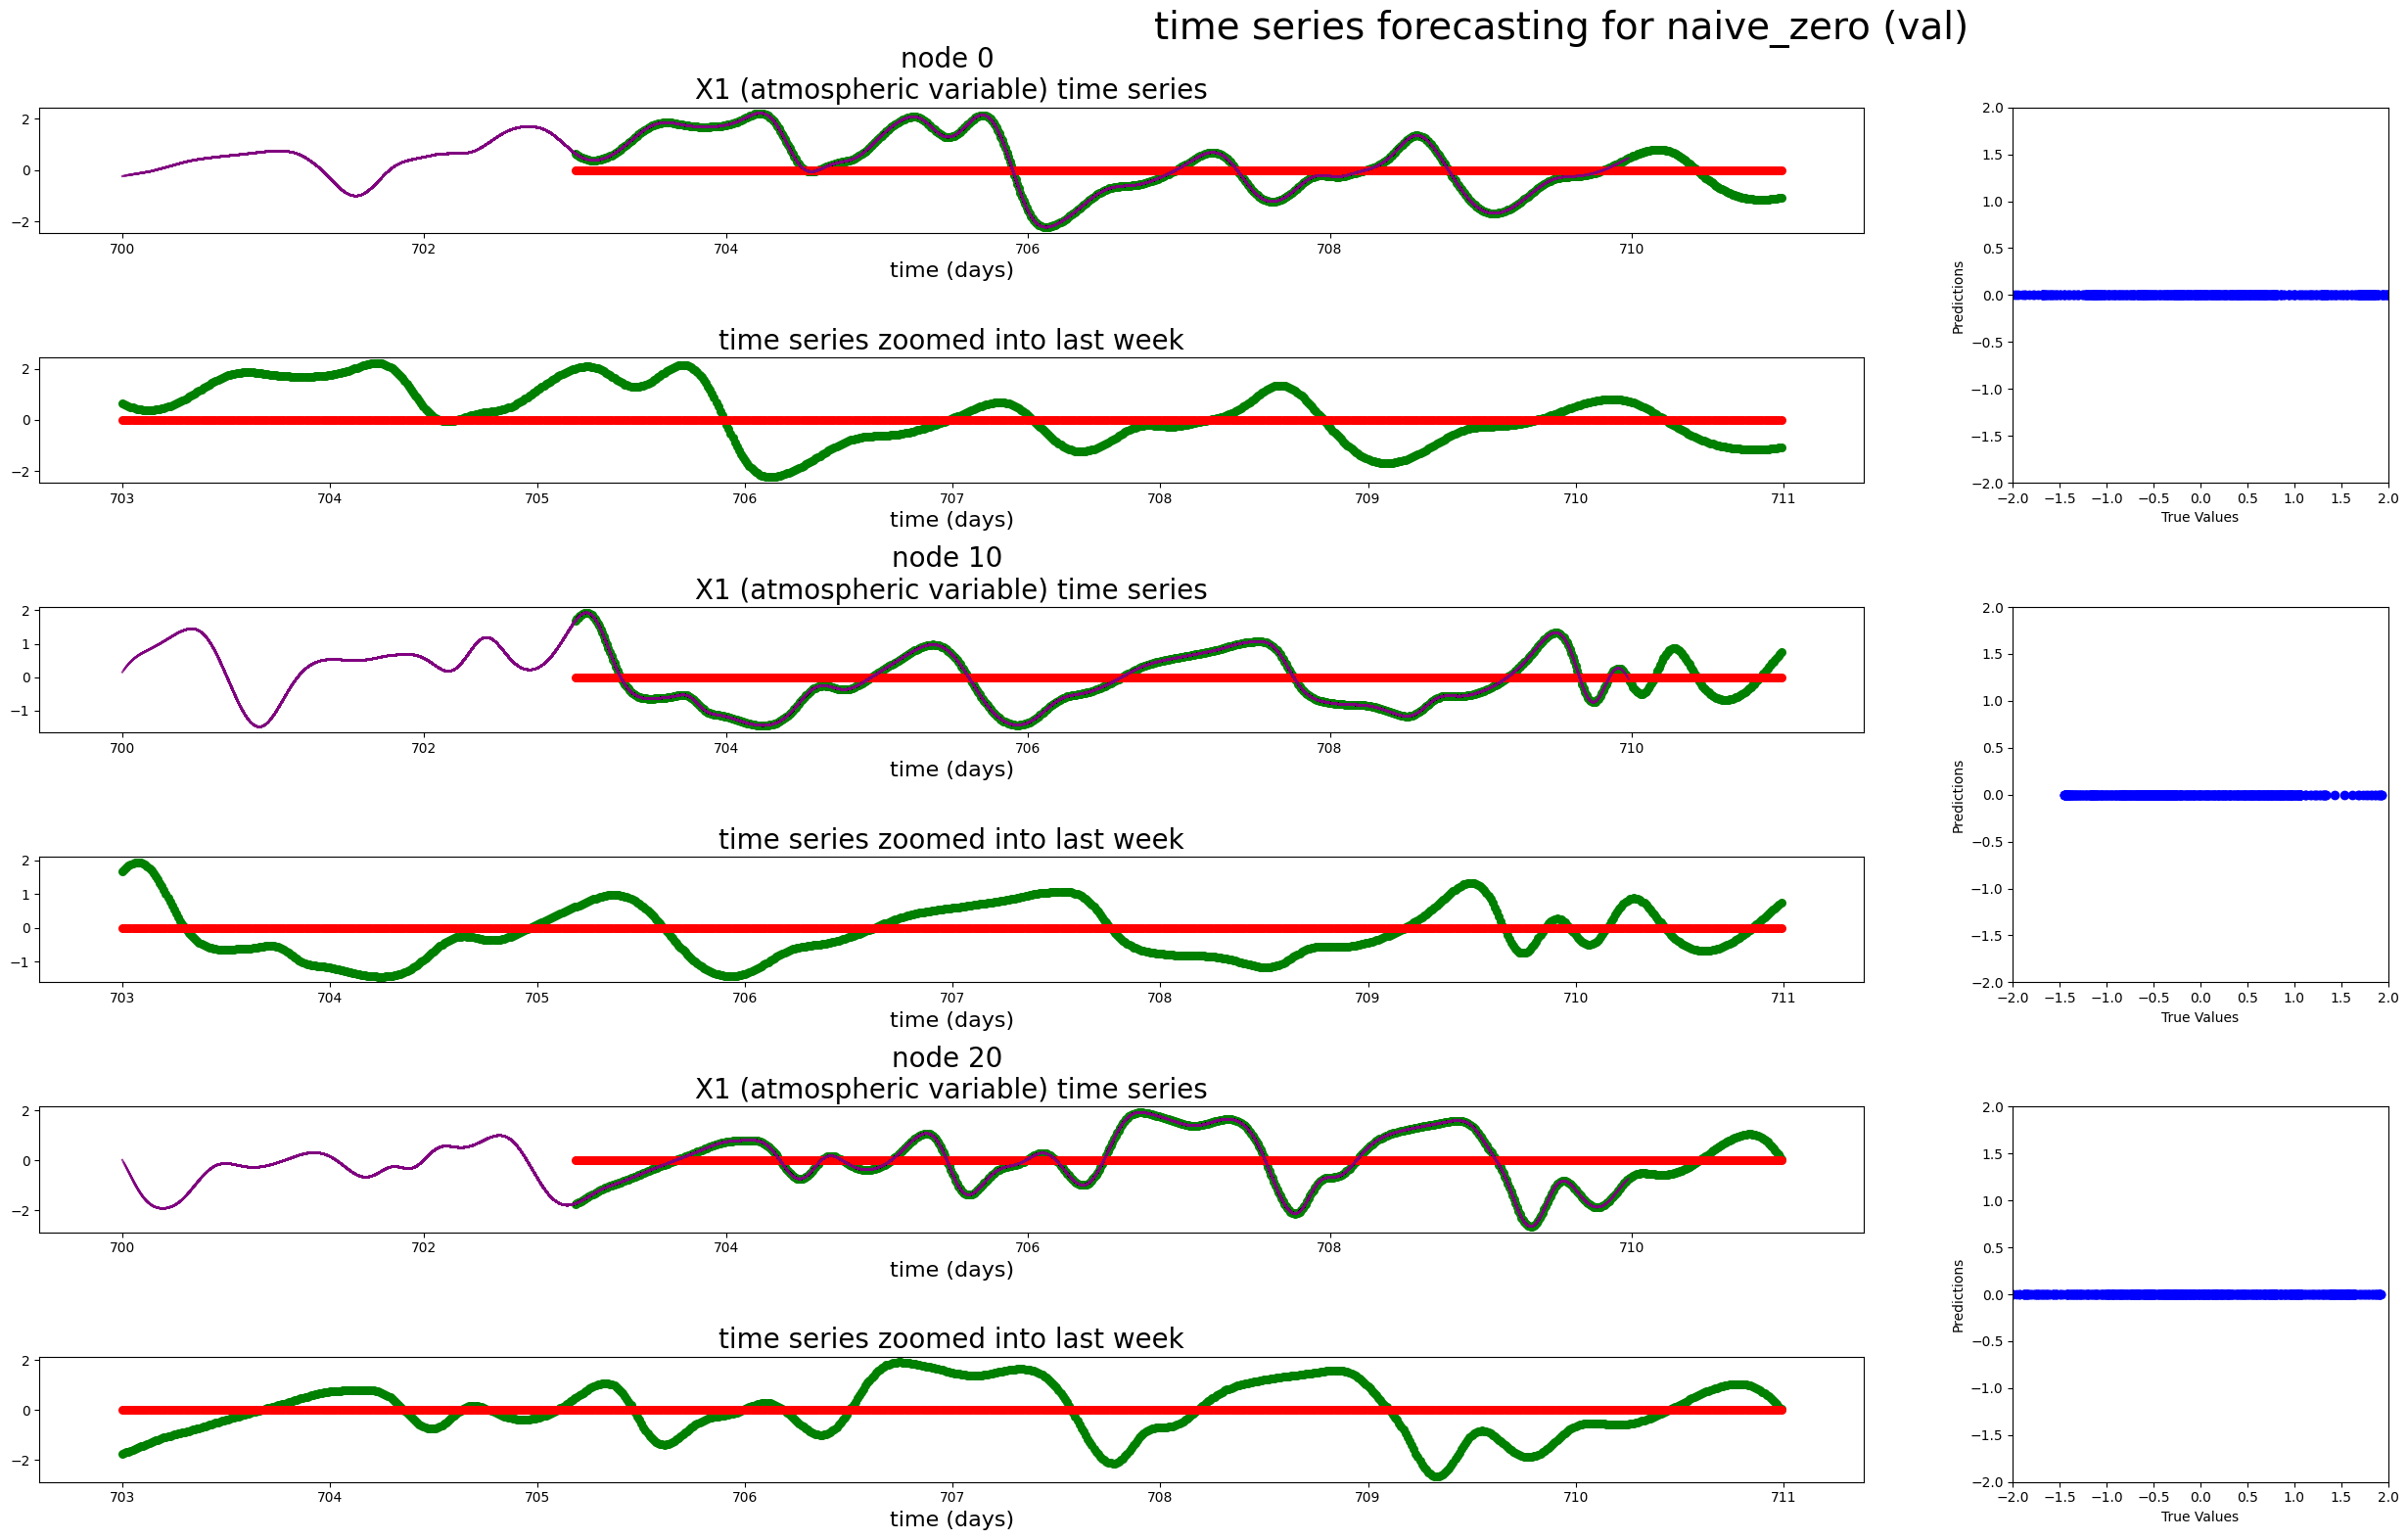

In [140]:
fig_train_loss, fig_train_pred, fig_val_pred = plot_model_results(
    train[:800], val[:800], naive_zero_model, model_name="naive_zero")

In [122]:
print('val performance: ')
naive_zero_model.evaluate(val_loader.load(), steps=val_loader.steps_per_epoch)


val performance: 
625/625 [==============================] - 2s 3ms/step - loss: 0.9909


0.9908871054649353

### NaiveConstant
predicts the output is equal to the last X1 value in the input window.

In [92]:
naive_constant_model = NaiveConstant()
naive_constant_model.compile(loss='mean_squared_error')

32/32 [==============================] - 0s 6ms/step


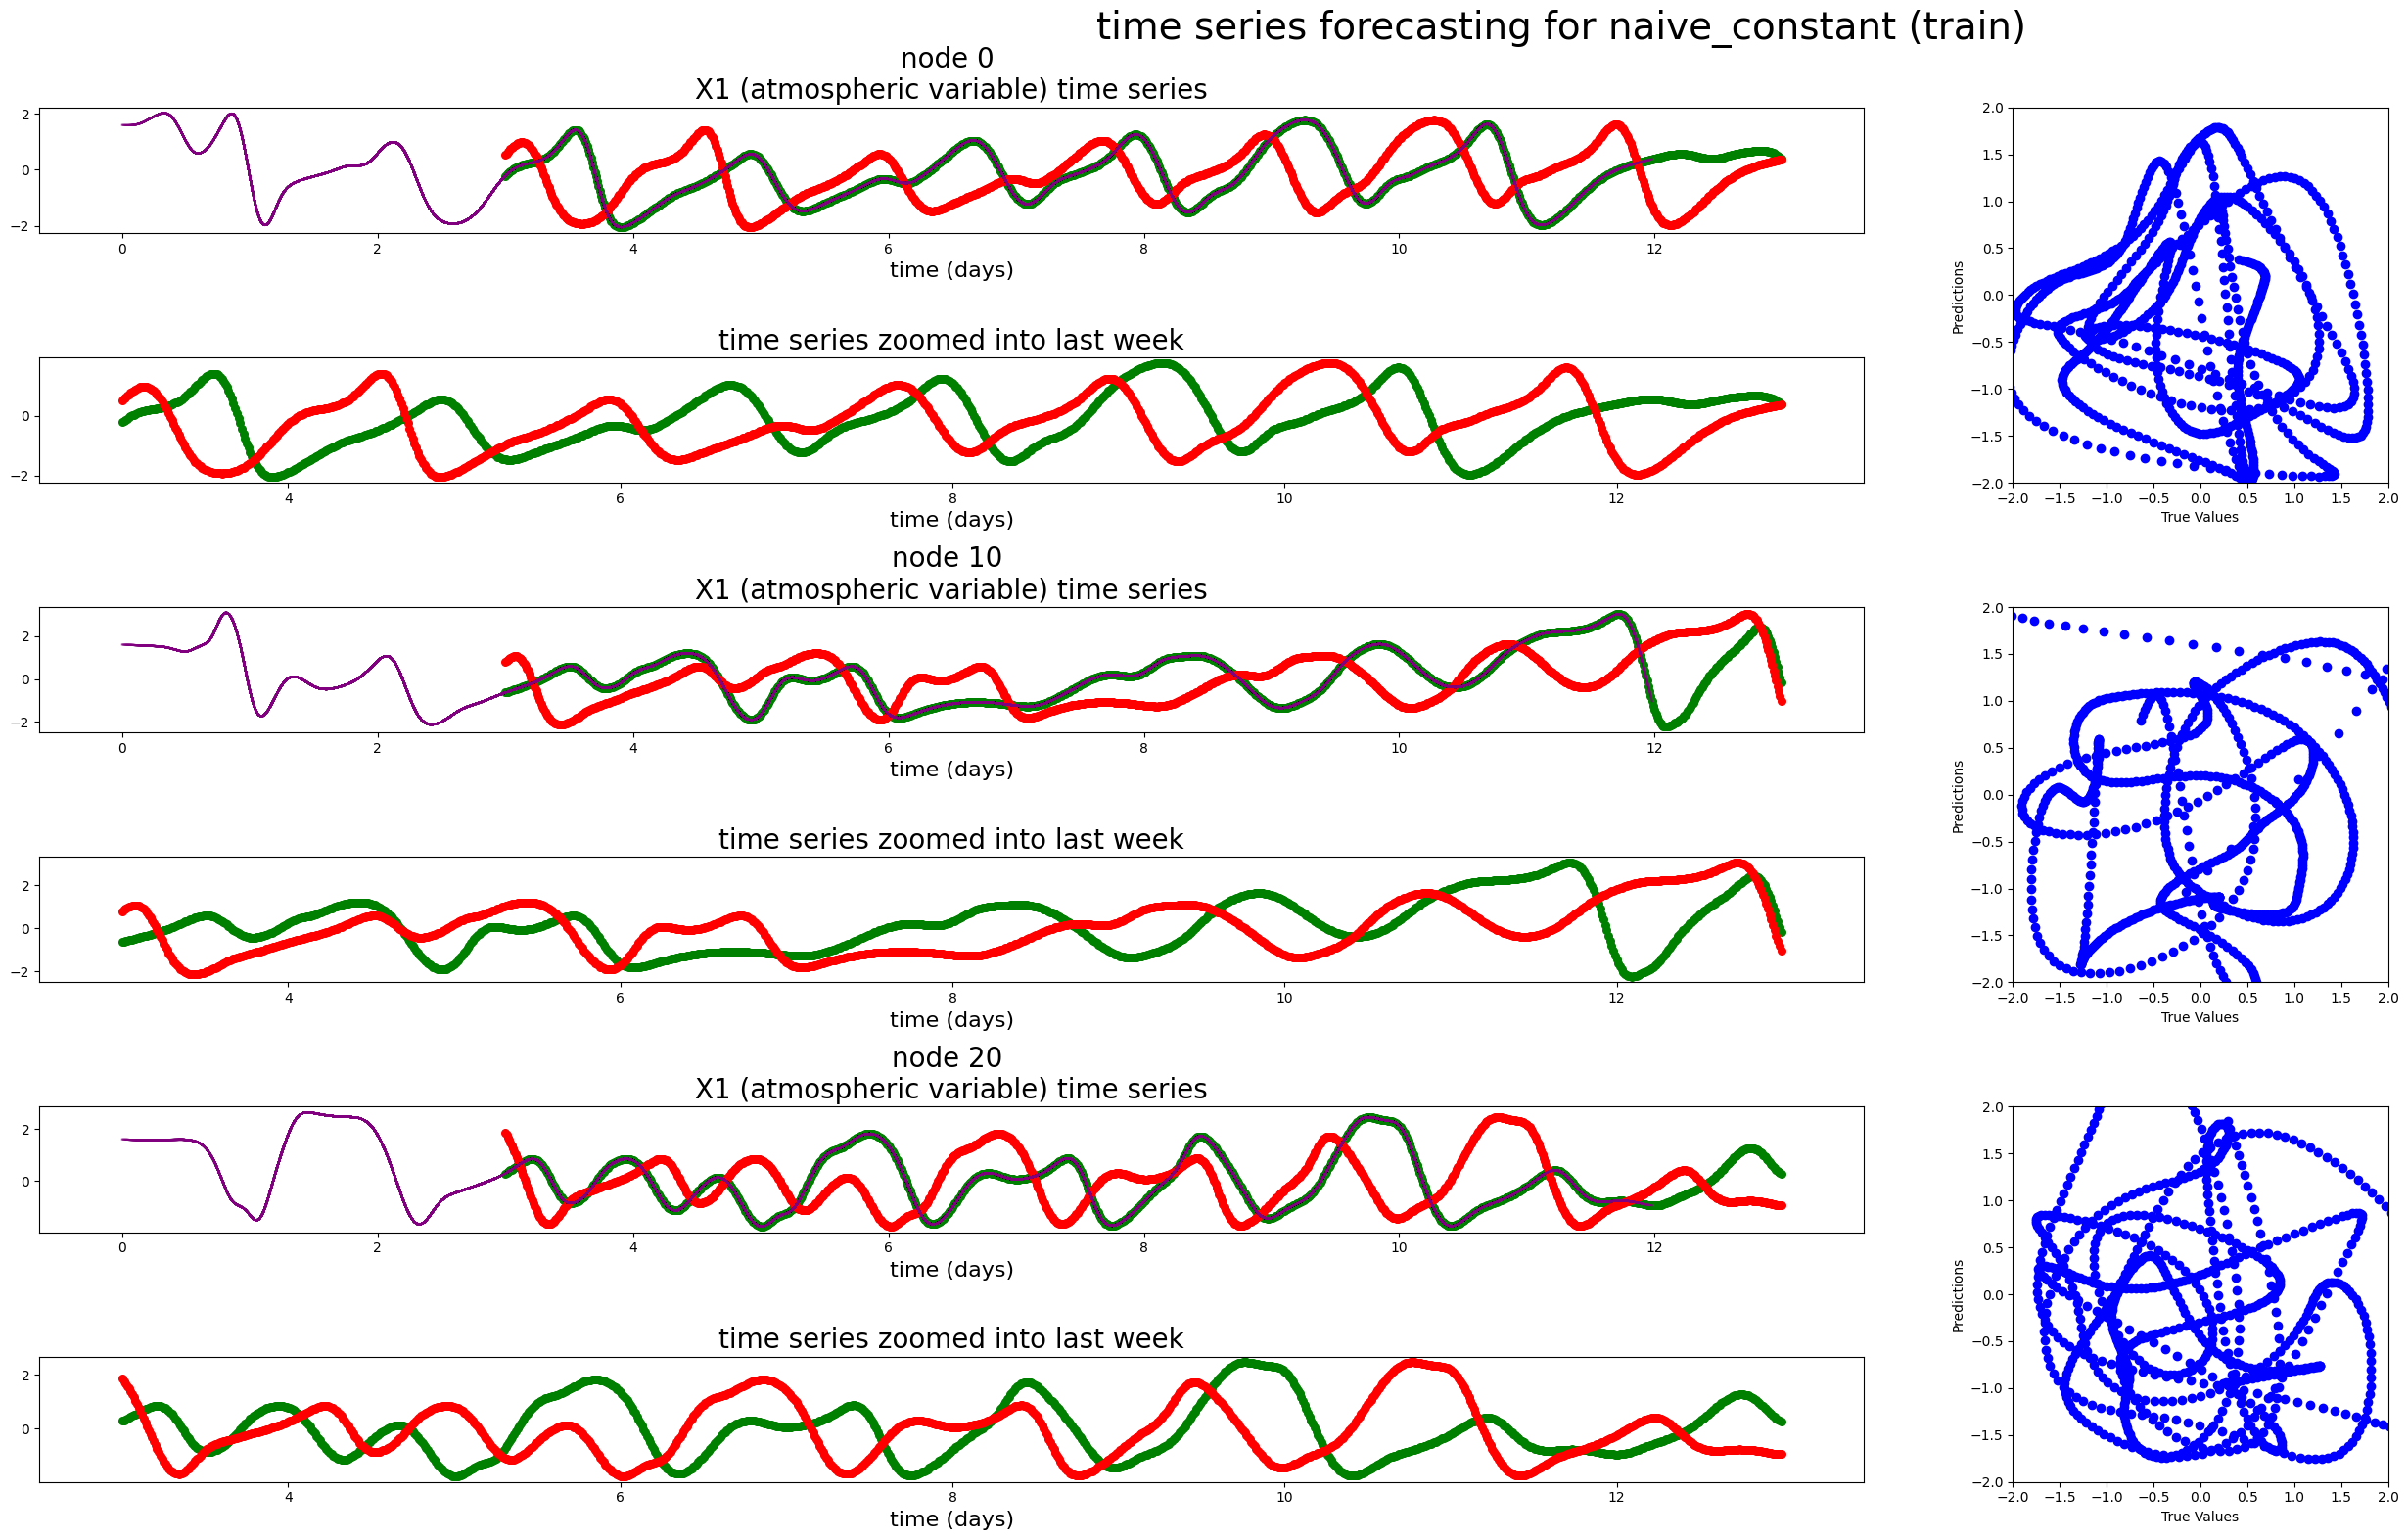

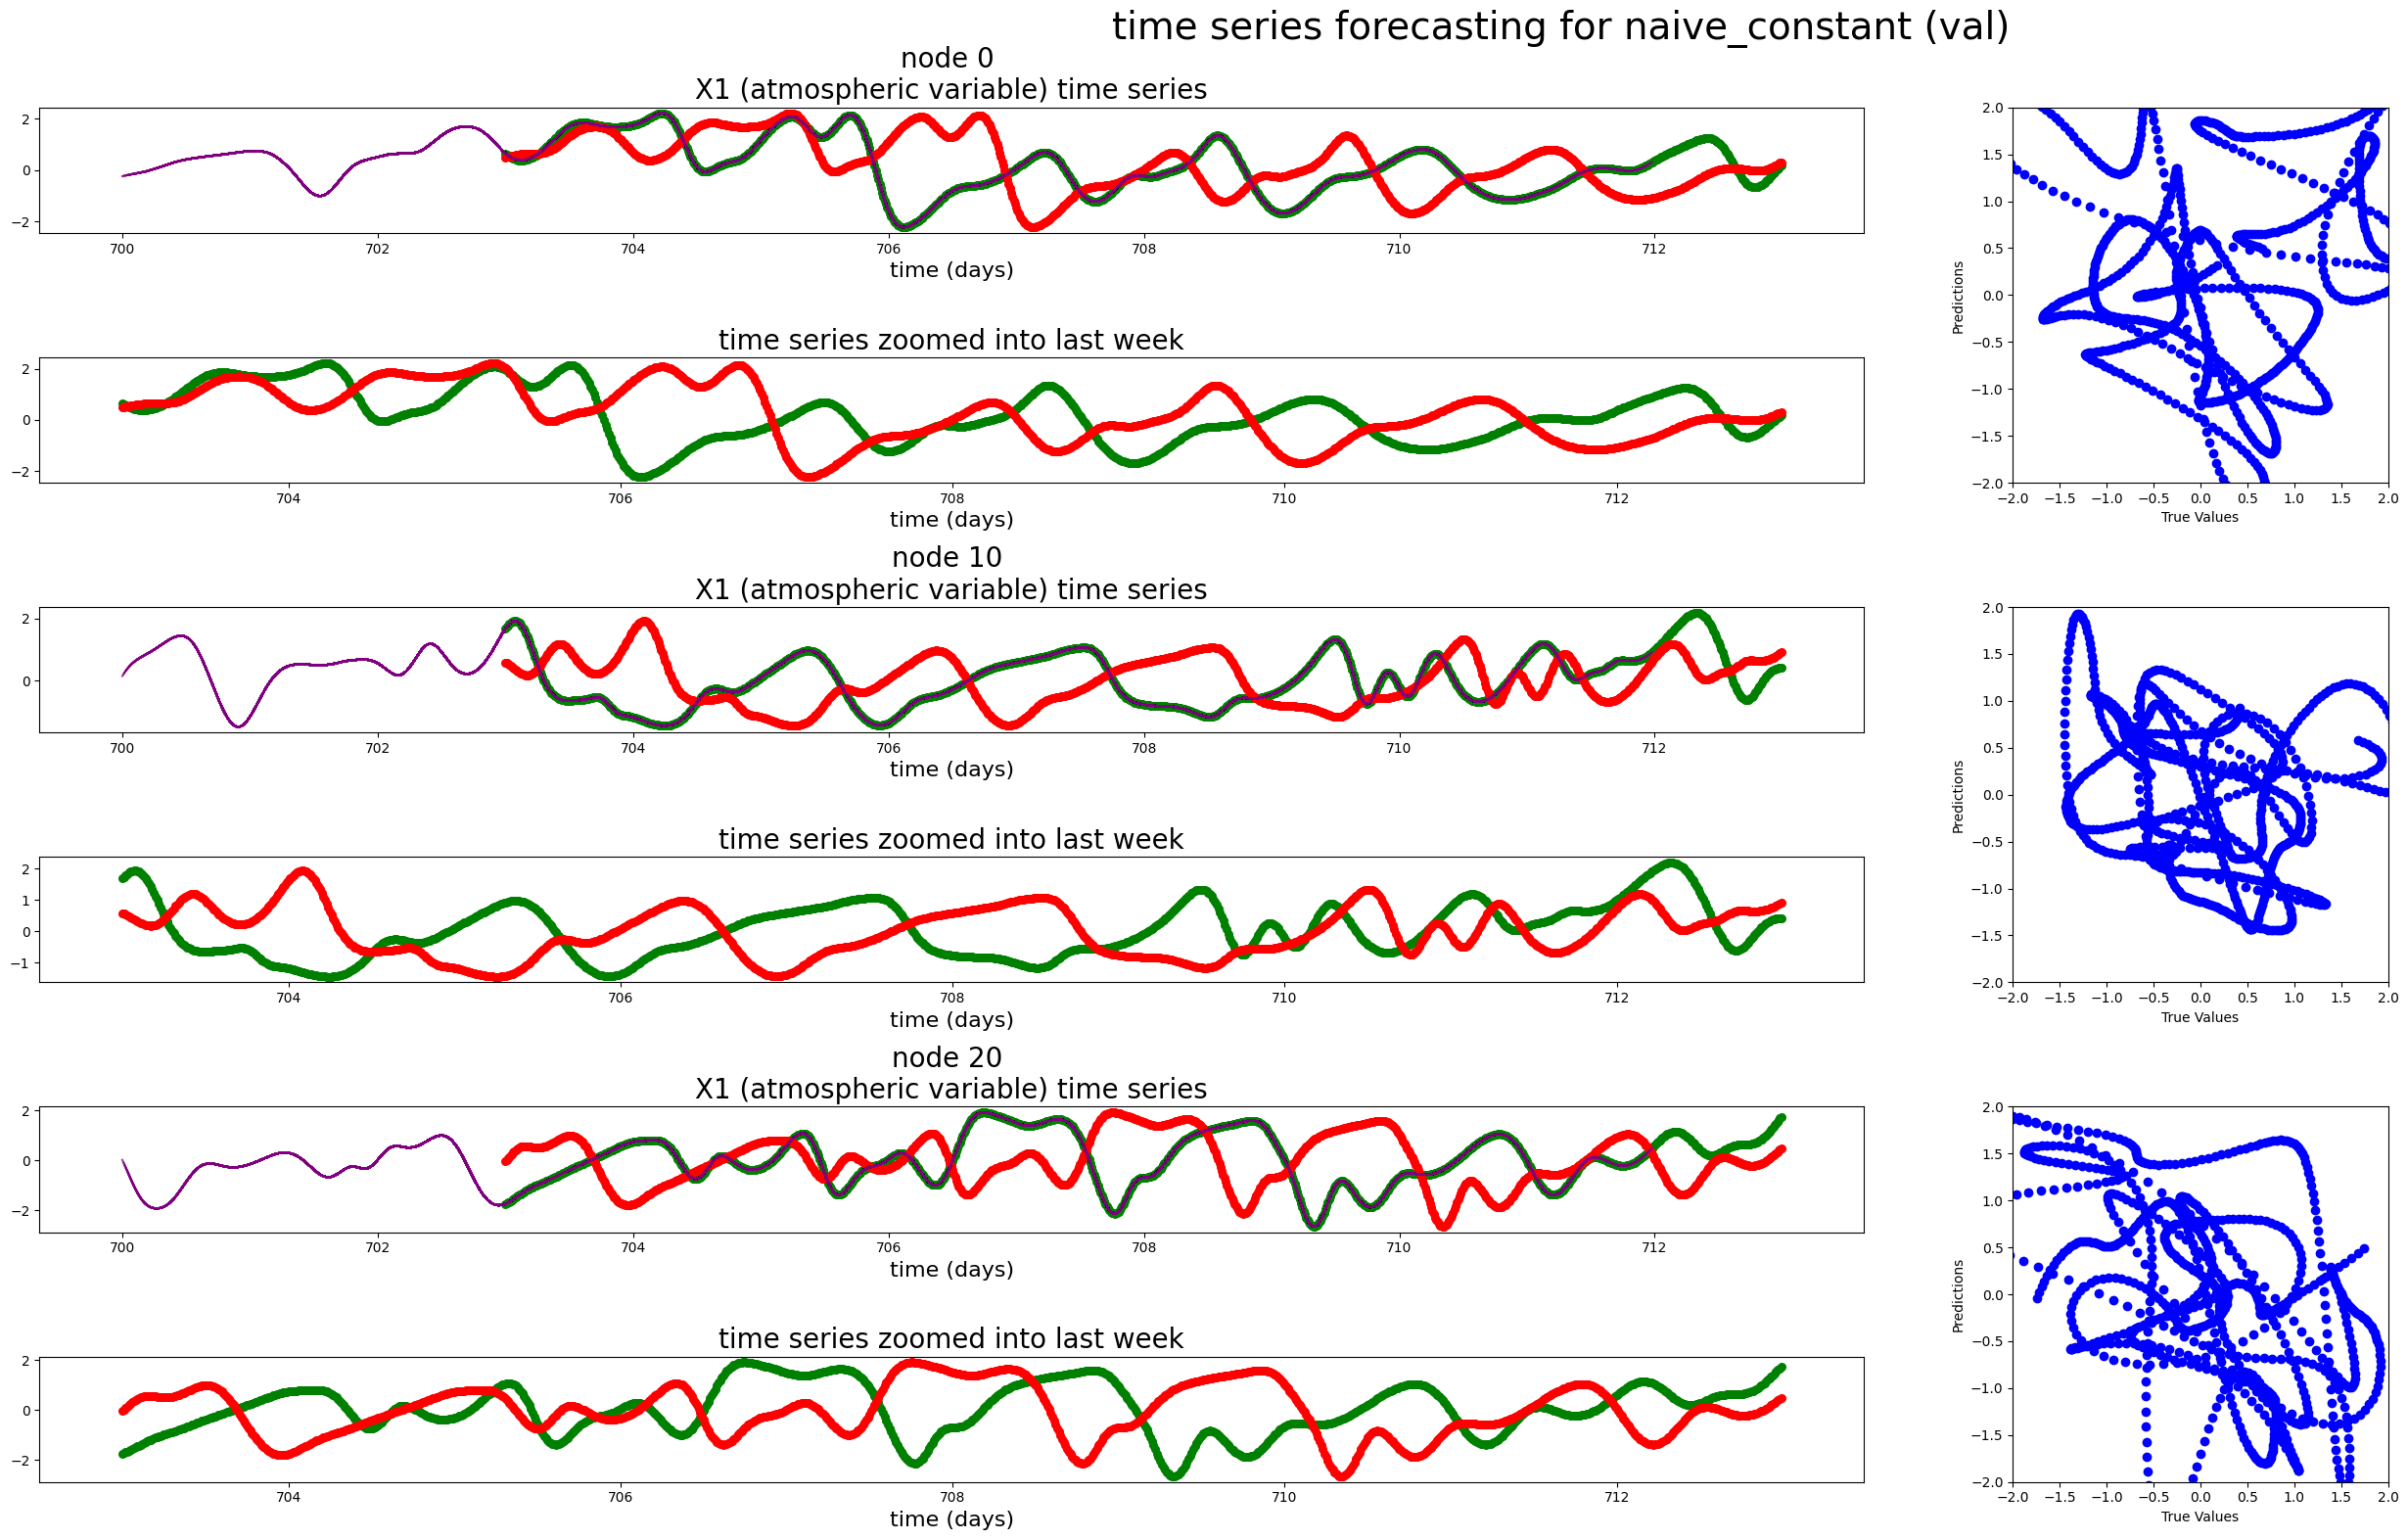

In [141]:
fig_train_loss, fig_train_pred, fig_val_pred = plot_model_results(
    train[:1000], val[:1000], naive_constant_model, model_name="naive_constant")

In [113]:
print('val performance: ')
naive_constant_model.evaluate(val_loader.load(), steps=val_loader.steps_per_epoch)


val performance: 
625/625 [==============================] - 4s 7ms/step - loss: 2.2864


2.286400079727173

### GCN out of the box

In [138]:
GCN_model, history = make_train_GCN(train, val, activation="relu", epochs=5, eval_val=True)

Epoch 1/5
2188/2188 [==============================] - 42s 18ms/step - loss: 1.5746 - val_loss: 1.1033
Epoch 2/5
2188/2188 [==============================] - 66s 30ms/step - loss: 1.0452 - val_loss: 0.9821
Epoch 3/5
2188/2188 [==============================] - 77s 35ms/step - loss: 0.9698 - val_loss: 0.9664
Epoch 4/5
2188/2188 [==============================] - 75s 34ms/step - loss: 0.9653 - val_loss: 0.9694
Epoch 5/5
2188/2188 [==============================] - 72s 33ms/step - loss: 0.9669 - val_loss: 0.9679


32/32 [==============================] - 1s 15ms/step


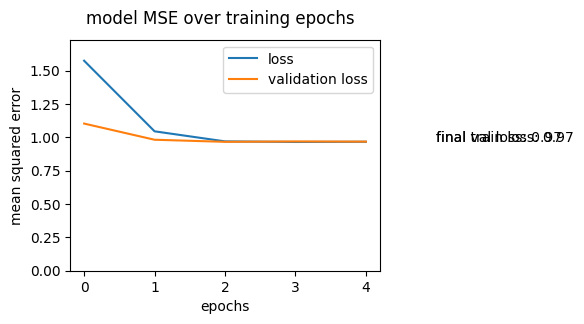

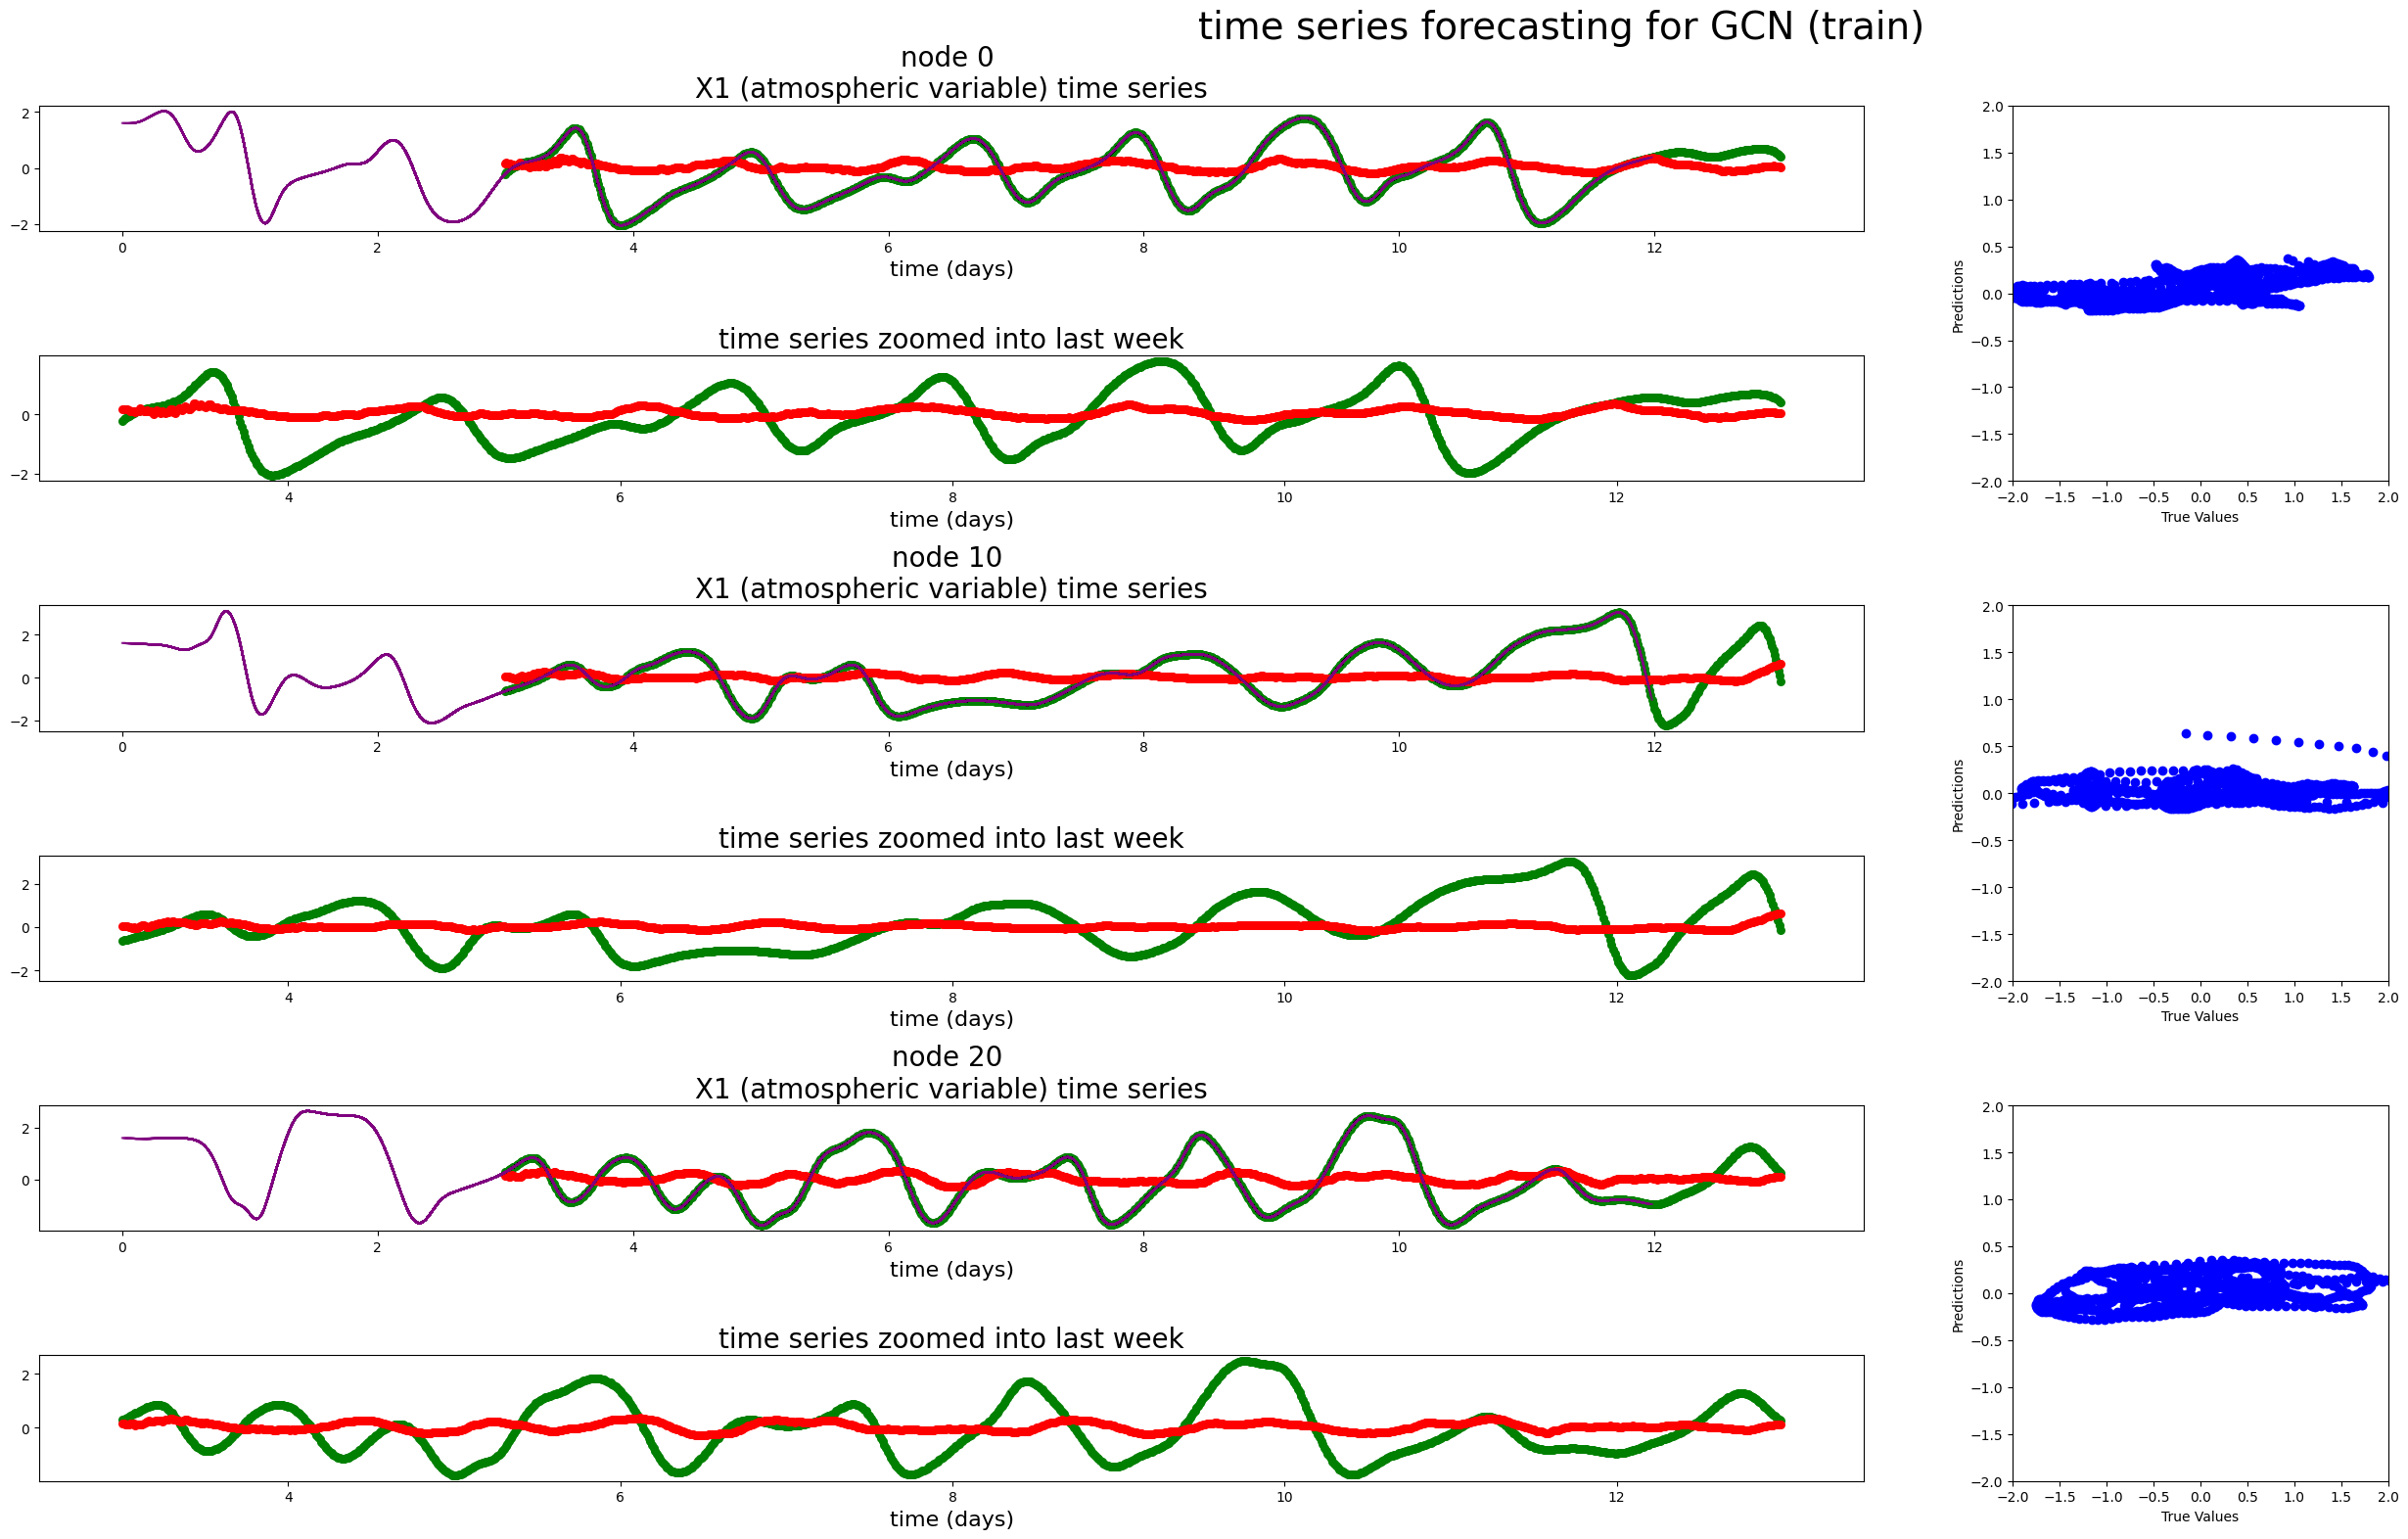

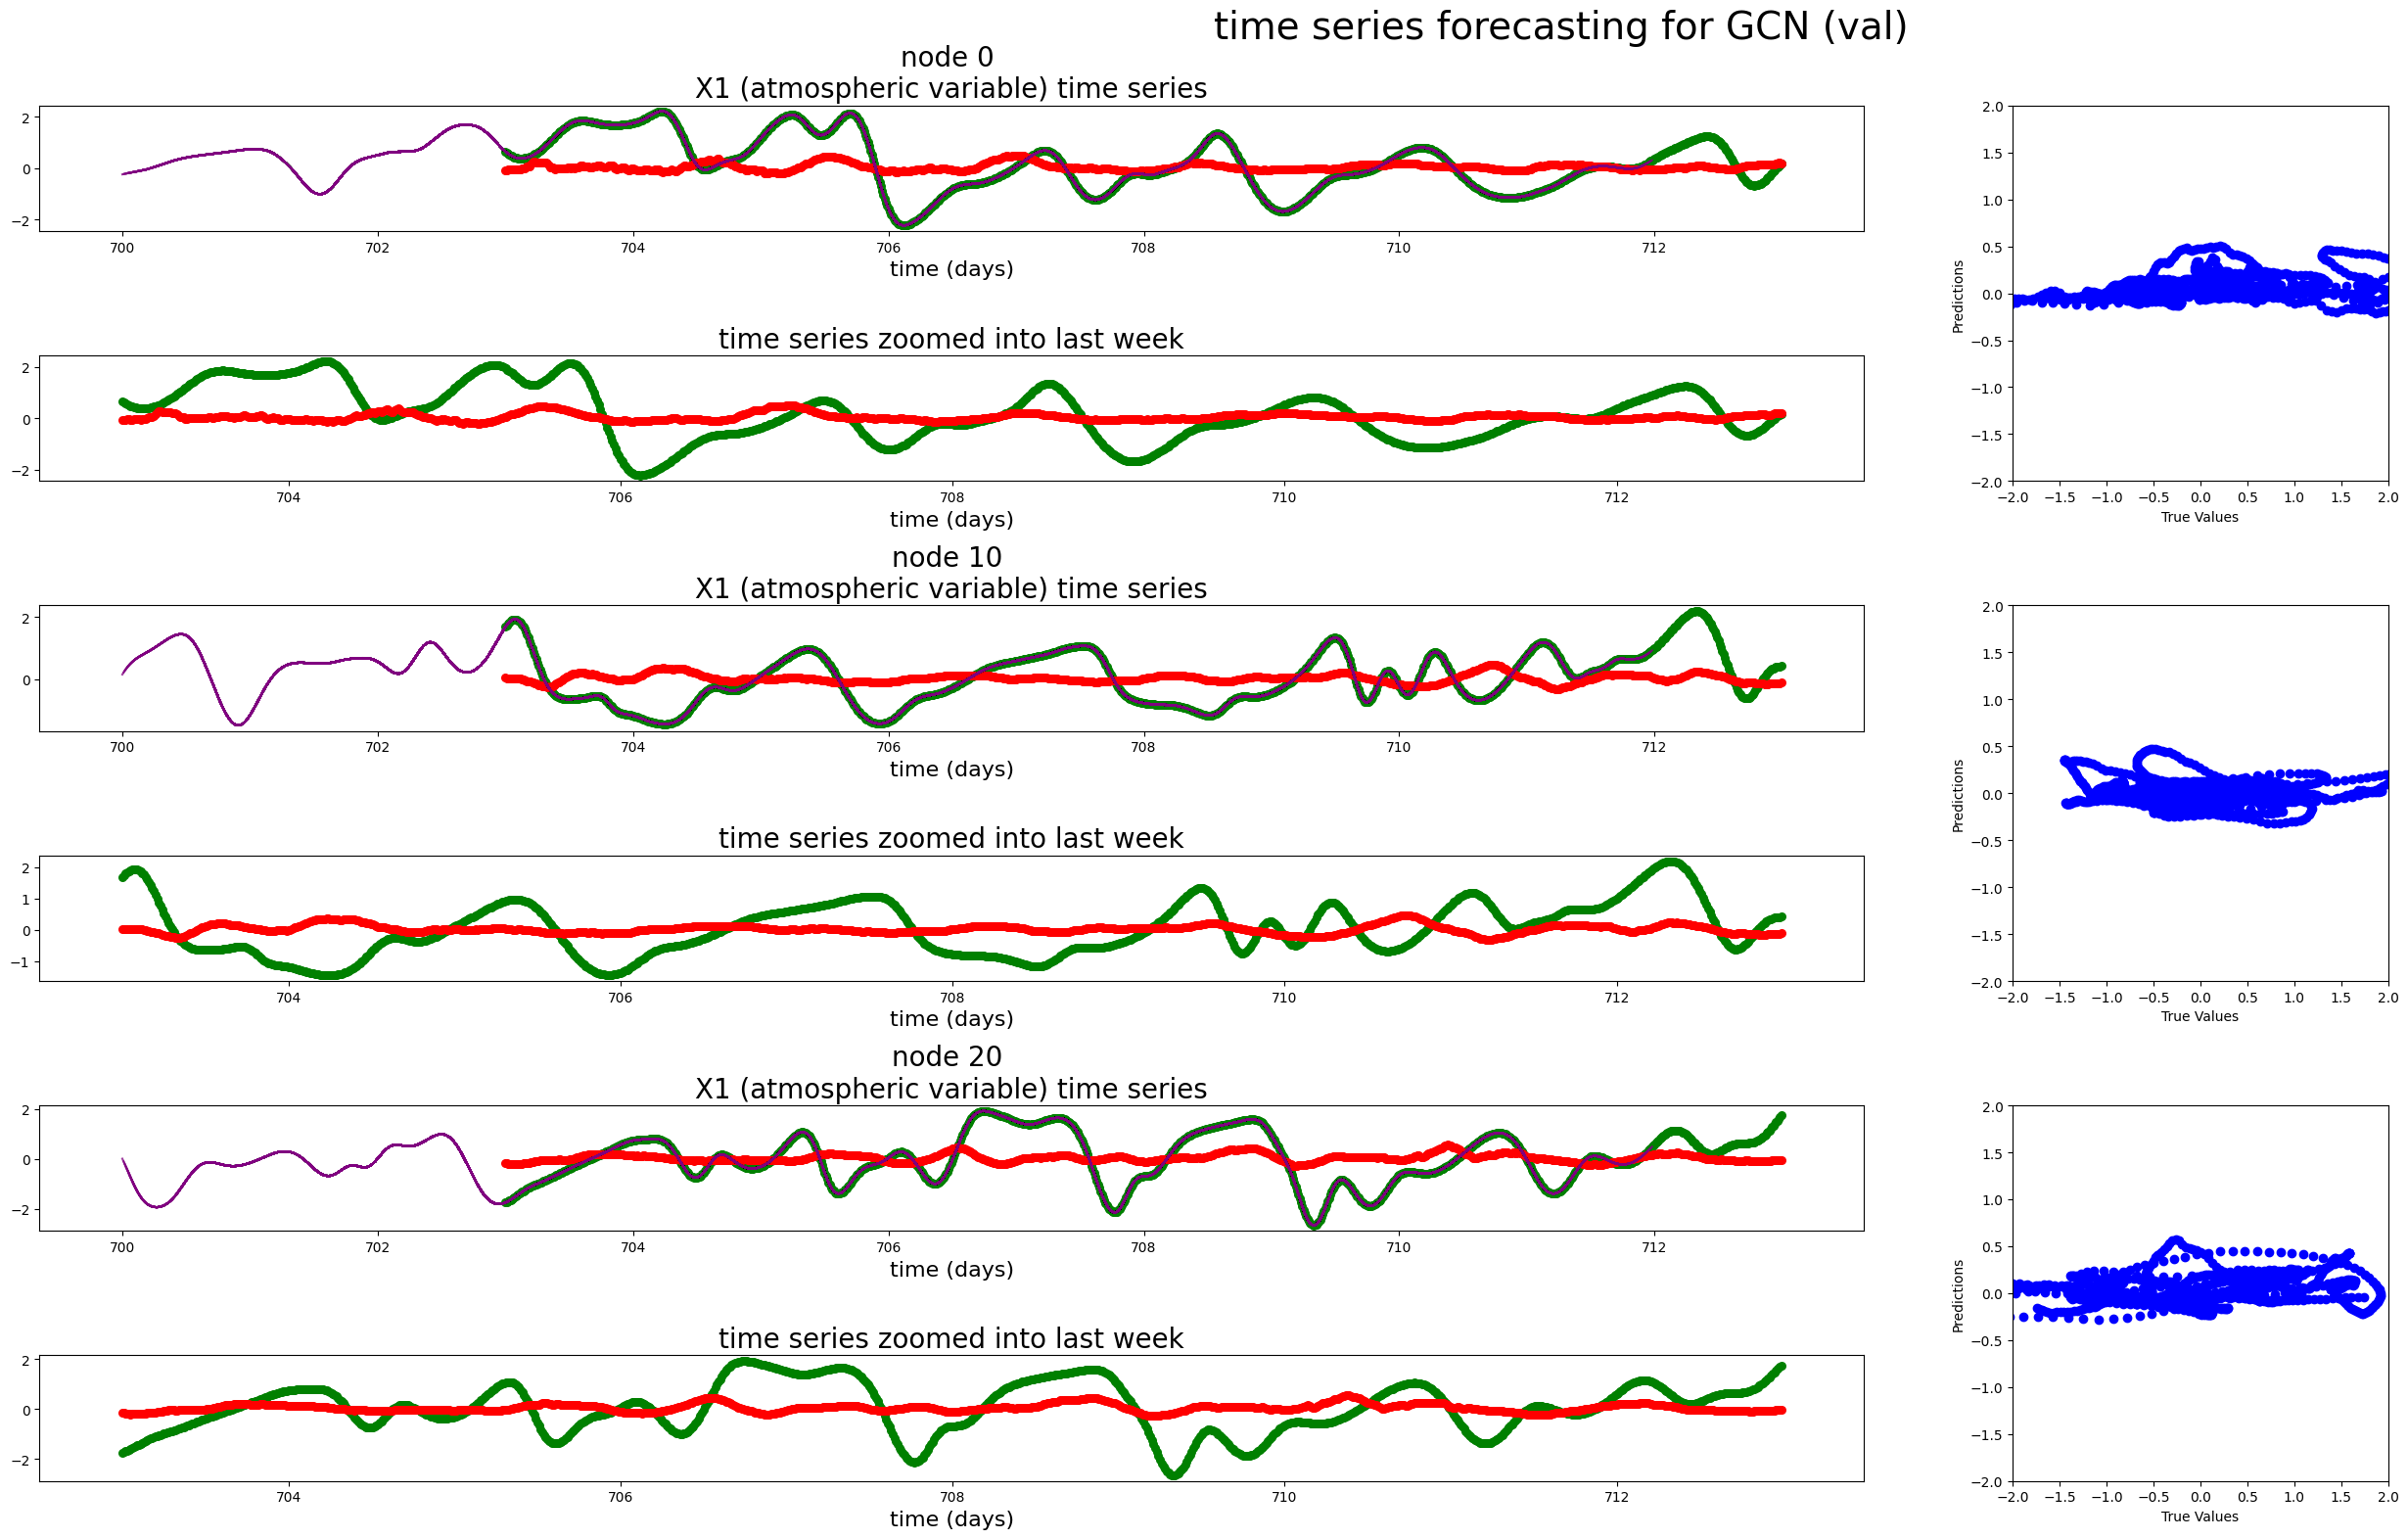

In [139]:
fig_train_loss, fig_train_pred, fig_val_pred = plot_model_results(
    train[:1000], val[:1000], GCN_model, history, model_name='GCN', epochs=5)

lol interesting, so the GCN learned that an efficient strategy is just to predict close to 0 for everything... this may be caused by using MSE as our choice of loss. 

In [143]:
GCN_model2, history = make_train_GCN(train, val, activation="relu", epochs=10, early_stopping=False, eval_val=True)

Epoch 1/10
2188/2188 [==============================] - 56s 25ms/step - loss: 1.7844 - val_loss: 1.2519
Epoch 2/10
2188/2188 [==============================] - 54s 24ms/step - loss: 1.0806 - val_loss: 0.9742
Epoch 3/10
2188/2188 [==============================] - 55s 25ms/step - loss: 0.9701 - val_loss: 0.9676
Epoch 4/10
2188/2188 [==============================] - 69s 32ms/step - loss: 0.9657 - val_loss: 0.9699
Epoch 5/10
2188/2188 [==============================] - 73s 33ms/step - loss: 0.9675 - val_loss: 0.9716
Epoch 6/10
2188/2188 [==============================] - 65s 30ms/step - loss: 0.9681 - val_loss: 0.9706
Epoch 7/10
2188/2188 [==============================] - 66s 30ms/step - loss: 0.9680 - val_loss: 0.9690
Epoch 8/10
2188/2188 [==============================] - 70s 32ms/step - loss: 0.9668 - val_loss: 0.9696
Epoch 9/10
2188/2188 [==============================] - 67s 31ms/step - loss: 0.9654 - val_loss: 0.9682
Epoch 10/10
2188/2188 [==============================] - 72s 33m

32/32 [==============================] - 1s 17ms/step


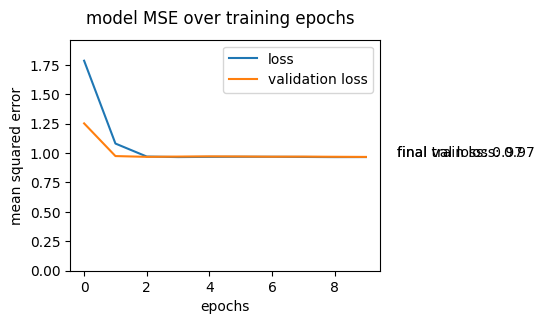

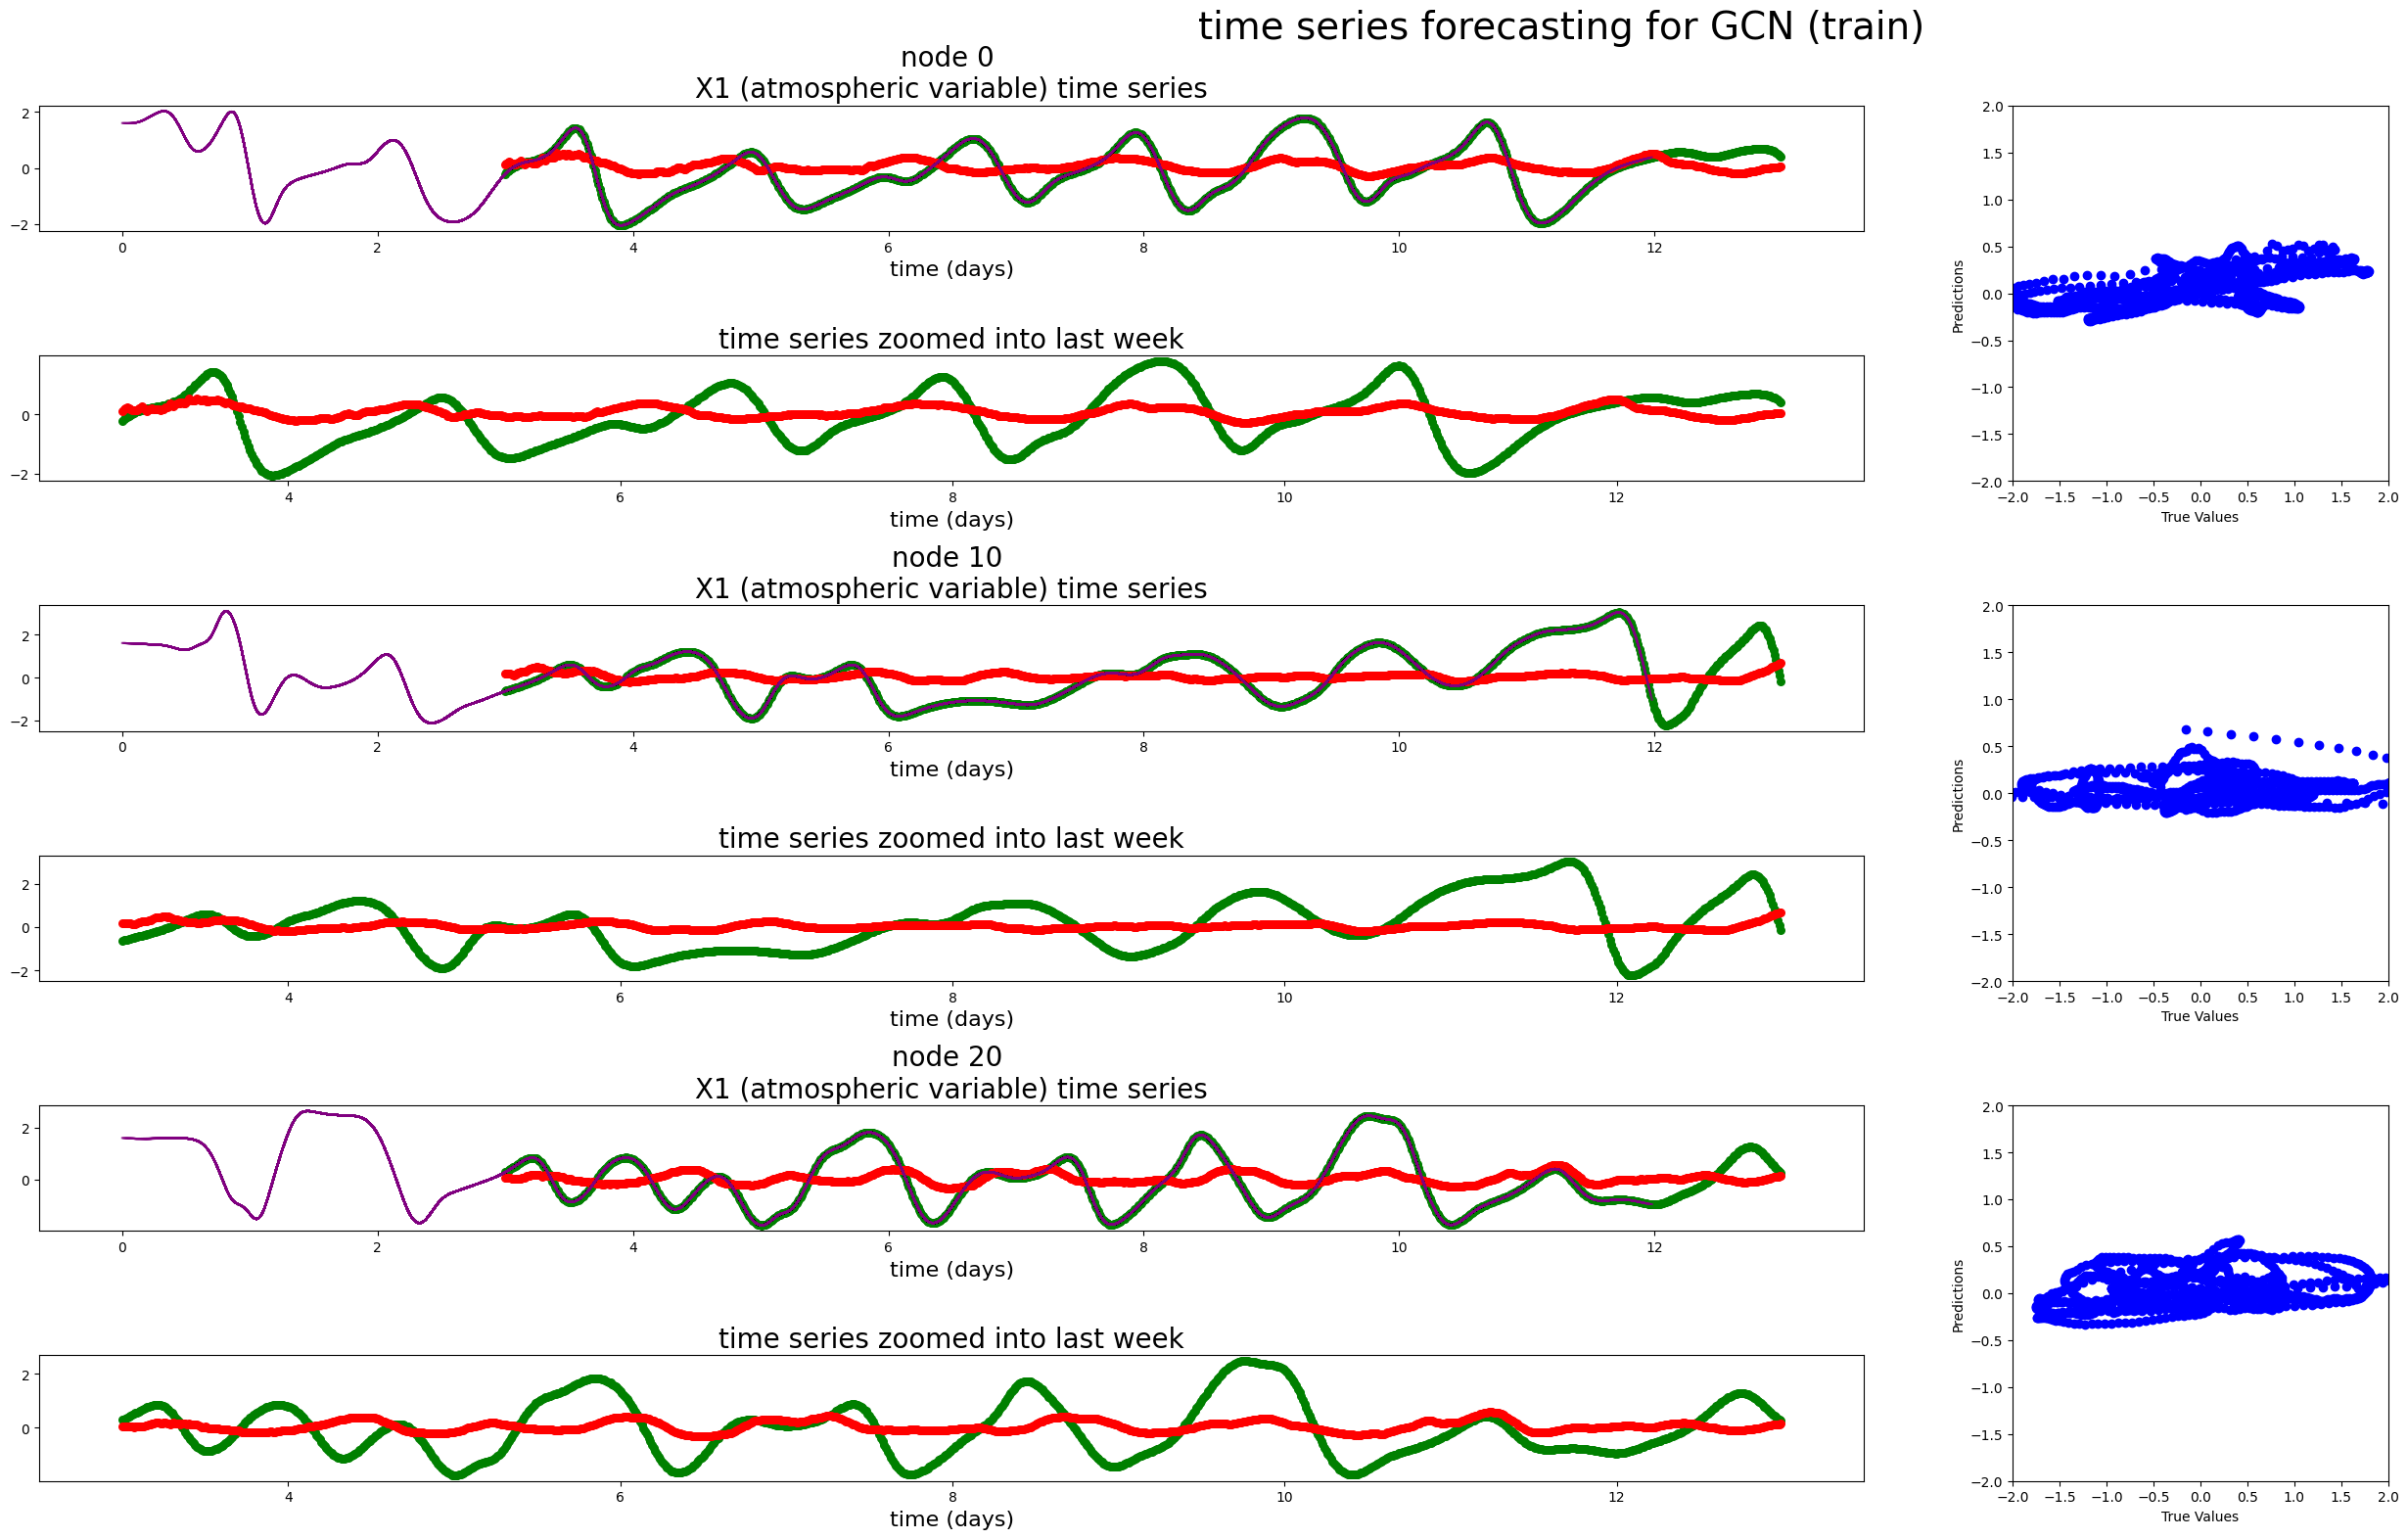

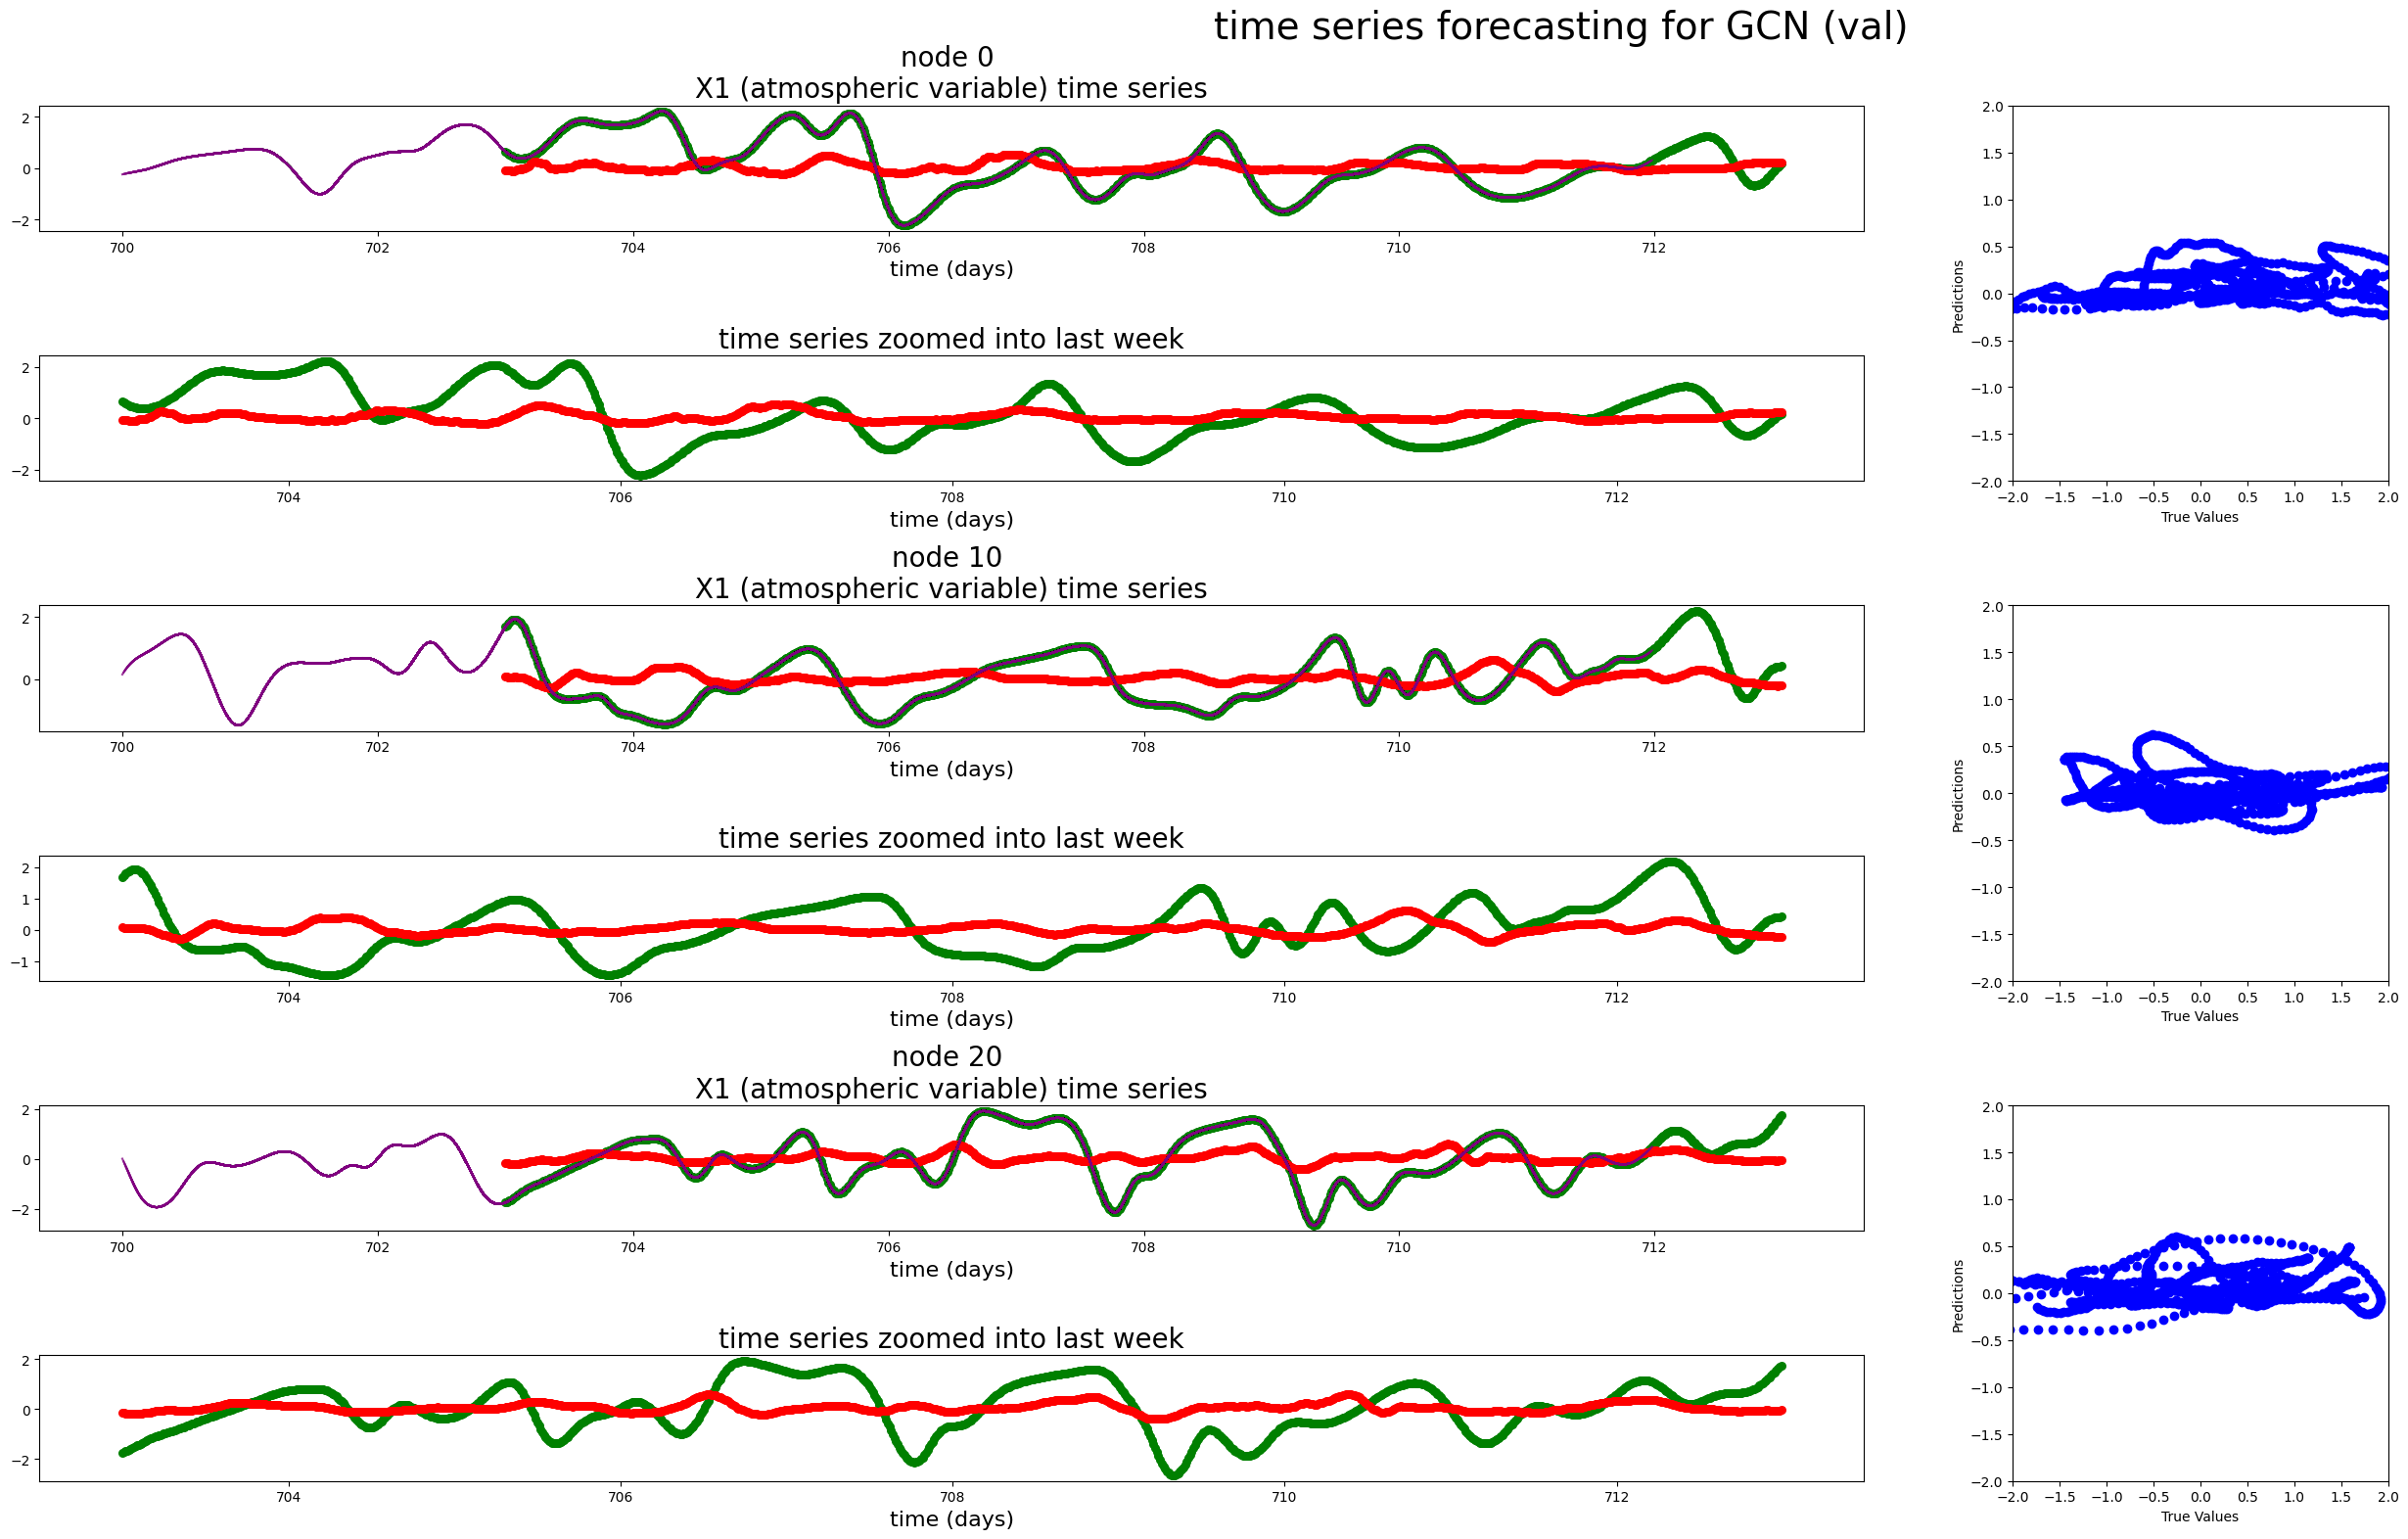

In [144]:
fig_train_loss, fig_train_pred, fig_val_pred = plot_model_results(
    train[:1000], val[:1000], GCN_model2, history, model_name='GCN', epochs=10)